### ONE Phyrexia Analysis ###

<h3>Imports</h3>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split


<h3>Data Transformation</h3>

Open up our data, from our raw data, we will select just the draft_id, pick, games_won, and pick_maindeck_rate, which we will preprocess into rows that look like [card in deck] [games won]. A deck will be able to have half cards since players may have changed deck composition mid way through the game.

In [41]:
df = pd.read_csv("ONE_premier_draft_data.csv", usecols = ['draft_id','event_match_wins', 'pick','pick_maindeck_rate'])

In [42]:
#Start our decks dataframe by finding all the unique drafts along with how many games they won
agg_functions = {'event_match_wins' : 'first'}
decks = df[['draft_id', 'event_match_wins']].groupby('draft_id').aggregate(agg_functions)

#Add one column to decks for each card in the set and initialize the values to 0
cards = df['pick'].unique()
new_cols = []
for card in cards:
    new_cols.append(card)
decks = decks.reindex(columns=decks.columns.tolist() + new_cols)   # add empty cols
decks[cards] = 0

#For each pick, we add the average number of copies that made the main deck
#Main deck rate is in [0,1] so if a card got picked twice and both copies 
#we in the main deck, we would have two rows that look like DRAFT, CARDNAME, 1
#so the resulting value of decks[DRAFT, CARDNAME] would be 2
for _, row in df[['draft_id', 'pick', 'pick_maindeck_rate']].iterrows():
    decks.loc[row['draft_id'],row['pick']] += row['pick_maindeck_rate']



#Only consider rows with a sum greater than 18
#Any deck with fewer cards is an outlier
#Note this is kinda hacky as we're still summing with the event_match_wins 
decks = decks.loc[(decks.sum(axis=1) > 18)]
decks['event_match_wins'] = decks['event_match_wins'].apply(lambda x: int(x >= 5))
decks = decks.round(0)

X_train, X_test, y_train, y_test = train_test_split(decks.loc[:, decks.columns != 'event_match_wins'], decks['event_match_wins'], test_size=0.2, random_state=42)


<h3>kNN-Model</h3>

Train: 1.0, Test: 0.6077140169332079
Train: 0.7958127499411903, Test: 0.6340545625587959
Train: 0.7508821453775583, Test: 0.6340545625587959
Train: 0.7254763585038815, Test: 0.658513640639699
Train: 0.7200658668548576, Test: 0.6745061147695203
Train: 0.7141848976711362, Test: 0.6782690498588899
Train: 0.7085391672547636, Test: 0.6820319849482597
Train: 0.702893436838391, Test: 0.6848541862652869
Train: 0.7007762879322512, Test: 0.6839134524929446
Train: 0.6974829451893672, Test: 0.6961429915333961
Train: 0.6996000940955069, Test: 0.6904985888993415
Train: 0.6965419901199718, Test: 0.6886171213546566
Train: 0.6967772288873206, Test: 0.6970837253057385
Train: 0.6930134086097389, Test: 0.6933207902163687
Train: 0.6918372147729945, Test: 0.6961429915333961
Train: 0.6941896024464832, Test: 0.6904985888993415
Train: 0.691131498470948, Test: 0.6961429915333961
Train: 0.6904257821689014, Test: 0.6989651928504234
Train: 0.6906610209362503, Test: 0.7046095954844779
Train: 0.6901905434015526, Tes

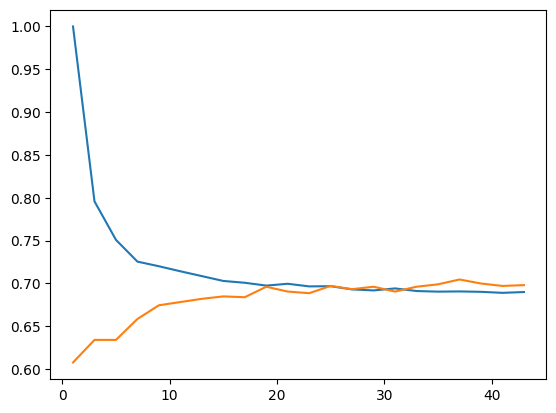

In [5]:
num_neighbors = range(1,45,2)
train_accuracies = []
test_accuracies = []
neigh = KNeighborsClassifier(n_neighbors=1)
for n in num_neighbors:
    neigh.n_neighbors = n
    neigh.fit(X_train, y_train)
    train_accuracy = neigh.score(X_train,y_train)
    train_accuracies.append(train_accuracy)
    test_accuracy = neigh.score(X_test,y_test)
    test_accuracies.append(test_accuracy)
    print(f"Train: {train_accuracy}, Test: {test_accuracy}")

plt.plot(num_neighbors, train_accuracies)
plt.plot(num_neighbors, test_accuracies)
plt.show()


This is the baseline we have to beat. If we can't get above this percentage we might as well just be guessing

In [45]:
total_winning_decks = decks["event_match_wins"].sum()
total_decks = decks["event_match_wins"].count()
print(total_winning_decks/total_decks)
print(1- total_winning_decks/total_decks)

0.27433337223984805
0.725666627760152


<h3>Naive Bayes</h3>

In [7]:
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler

gnb = GaussianNB()
scaler = StandardScaler()
gaussian_X_train = scaler.fit_transform(X_train)
gnb.fit(gaussian_X_train, y_train)
gaussian_X_test = scaler.transform(X_test)
accuracy = gnb.score(gaussian_X_test, y_test)
print(f"Gaussian Naive Bayes Accuracy: {accuracy}")

Gaussian Naive Bayes Accuracy: 0.38005644402634053


<h3>Random Forest</h3>

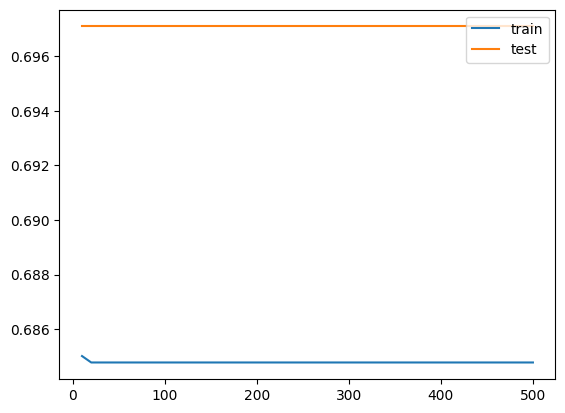

In [8]:
from sklearn.ensemble import RandomForestClassifier

num_trees = range(10, 501, 10)
train_accuracies = []
test_accuracies = []
for n in num_trees:
    random_forest = RandomForestClassifier(n_estimators=n, max_depth=4)
    random_forest.fit(X_train, y_train)
    train_accuracy = random_forest.score(X_train,y_train)
    train_accuracies.append(train_accuracy)
    test_accuracy = random_forest.score(X_test,y_test)
    test_accuracies.append(test_accuracy)

plt.plot(num_trees, train_accuracies, label="train")
plt.plot(num_trees, test_accuracies, label="test")
plt.legend(loc="upper right")
plt.show()

<h3>PyTorch / Neural Net</h3>

In [46]:
import torch
from torch import nn, Tensor
from torch.utils.data import TensorDataset, DataLoader

# Create data loaders.
batch_size = 64
train_tensor = TensorDataset(Tensor(X_train.values), Tensor(y_train.values).type(torch.LongTensor))
test_tensor = TensorDataset(Tensor(X_test.values), Tensor(y_test.values).type(torch.LongTensor))
train_data = DataLoader(train_tensor, batch_size=batch_size, shuffle=True)
test_data = DataLoader(test_tensor, batch_size=batch_size, shuffle=True)

In [65]:
%autoreload 2
import DraftNeuralNet

device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"

model = DraftNeuralNet.NeuralNet(len(cards)).to(device)
print(len(cards))
print(model)

loss_fn = torch.nn.CrossEntropyLoss(reduction='sum')
optimizer = torch.optim.SGD(model.parameters(), lr=1e-5)
num_epochs = 50

for epoch in range(num_epochs):
    DraftNeuralNet.train(train_data, model, loss_fn, optimizer, device)
    if epoch % 5 == 0:
        DraftNeuralNet.test(train_data, model, loss_fn, device)



265
NeuralNet(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=265, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=2, bias=True)
  )
)
Test Error: 
 Accuracy: 72.6%, Avg loss: 41.224219 

Test Error: 
 Accuracy: 72.6%, Avg loss: 37.593593 

Test Error: 
 Accuracy: 72.6%, Avg loss: 37.483209 

Test Error: 
 Accuracy: 72.6%, Avg loss: 37.409094 

Test Error: 
 Accuracy: 72.6%, Avg loss: 37.336650 

Test Error: 
 Accuracy: 72.6%, Avg loss: 37.264549 

Test Error: 
 Accuracy: 72.6%, Avg loss: 37.190394 

Test Error: 
 Accuracy: 72.6%, Avg loss: 37.116758 

Test Error: 
 Accuracy: 72.6%, Avg loss: 37.045027 

Test Error: 
 Accuracy: 72.6%, Avg loss: 36.974298 

